# Nettoyage de la base de données sur les demandes de valeurs foncières

## Setup 

In [44]:
# from google.colab import drive
# drive.mount("/content/drive")

# import os 
# os.chdir("./drive/MyDrive/Business Data Challenge/business-data-challenge/code/cleaning/")

# !pip install rich

In [1]:
DATA_DIR = "../../data/"
ZIP_DIR = f"{DATA_DIR}dvf.zip"

ZIP_CODE_DIR = f"{DATA_DIR}french-zip-code/"
DENSITY_DIR = f"{DATA_DIR}densite/"

In [42]:
import pandas as pd 
import zipfile

import numpy as np 

from rich import print 

import matplotlib.pyplot as plt 
import seaborn as sns


from haversine import haversine, Unit

In [3]:
from pandas.core.frame import DataFrame
from typing import Tuple 

In [4]:
pd.set_option("display.max_columns", None)
# pd.set_option("display.max_rows", None)

In [45]:
# test calcul distance via haversine

lyon = (45.7597, 4.8422) # (latitude, longitude)
paris = (48.8567, 2.3508)

haversine(lyon, paris, unit=Unit.KILOMETERS)

392.2172595594006

## Chargement des données

In [5]:
def load_zip_dvf(zip_dir: str, year: int) -> DataFrame: 
    zf = zipfile.ZipFile(zip_dir) 
    file_name = f"dvf/{year}.csv"

    df = pd.read_csv(zf.open(file_name))
    return df 

df = load_zip_dvf(ZIP_DIR, year=2021)

C:\Users\pemma\AppData\Local\Temp/ipykernel_15228/3827336401.py:8: DtypeWarning: Columns (10,12,14,17,18,20,22,24,35,36) have mixed types.Specify dtype option on import or set low_memory=False.
  df = load_zip_dvf(ZIP_DIR, year=2021)


In [6]:
df.head()

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,id_parcelle,ancien_id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
0,2021-1,2021-01-05,1,Vente,185000.0,5080.0,NaN,CHE DE VOGELAS,0471,1370.0,1426,Val-Revermont,1,NaN,NaN,01426312ZC0122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,Maison,97.0,5.0,S,sols,NaN,NaN,2410.0,5.386094,46.327140
1,2021-1,2021-01-05,1,Vente,185000.0,5080.0,NaN,CHE DE VOGELAS,0471,1370.0,1426,Val-Revermont,1,NaN,NaN,01426312ZC0122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3.0,Dépendance,NaN,0.0,S,sols,NaN,NaN,2410.0,5.386094,46.327140
2,2021-2,2021-01-06,1,Vente,10.0,NaN,NaN,ROUGEMONT,B043,1290.0,1042,Bey,1,NaN,NaN,010420000A0204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,BT,taillis simples,NaN,NaN,530.0,4.844368,46.224233
3,2021-3,2021-01-04,1,Vente,204332.0,7.0,NaN,ALL DES ECUREUILS,0276,1310.0,1065,Buellas,1,NaN,NaN,010650000B1325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,Maison,88.0,4.0,S,sols,NaN,NaN,866.0,5.157688,46.200988
4,2021-4,2021-01-06,1,Vente,320000.0,87.0,NaN,RTE DE CERTINES,0140,1250.0,1254,Montagnat,1,NaN,NaN,01254000AZ0011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3.0,Dépendance,NaN,0.0,S,sols,NaN,NaN,1426.0,5.273260,46.156334


In [7]:
df.shape

(4375223, 40)

In [8]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4375223 entries, 0 to 4375222
Data columns (total 40 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   id_mutation                   object 
 1   date_mutation                 object 
 2   numero_disposition            int64  
 3   nature_mutation               object 
 4   valeur_fonciere               float64
 5   adresse_numero                float64
 6   adresse_suffixe               object 
 7   adresse_nom_voie              object 
 8   adresse_code_voie             object 
 9   code_postal                   float64
 10  code_commune                  object 
 11  nom_commune                   object 
 12  code_departement              object 
 13  ancien_code_commune           float64
 14  ancien_nom_commune            object 
 15  id_parcelle                   object 
 16  ancien_id_parcelle            float64
 17  numero_volume                 object 
 18  lot1_numero           

None

## Preprocessing de base

### Suppression des variables inutiles

In [9]:
print(df.columns.tolist())

[
    'id_mutation',
    'date_mutation',
    'numero_disposition',
    'nature_mutation',
    'valeur_fonciere',
    'adresse_numero',
    'adresse_suffixe',
    'adresse_nom_voie',
    'adresse_code_voie',
    'code_postal',
    'code_commune',
    'nom_commune',
    'code_departement',
    'ancien_code_commune',
    'ancien_nom_commune',
    'id_parcelle',
    'ancien_id_parcelle',
    'numero_volume',
    'lot1_numero',
    'lot1_surface_carrez',
    'lot2_numero',
    'lot2_surface_carrez',
    'lot3_numero',
    'lot3_surface_carrez',
    'lot4_numero',
    'lot4_surface_carrez',
    'lot5_numero',
    'lot5_surface_carrez',
    'nombre_lots',
    'code_type_local',
    'type_local',
    'surface_reelle_bati',
    'nombre_pieces_principales',
    'code_nature_culture',
    'nature_culture',
    'code_nature_culture_speciale',
    'nature_culture_speciale',
    'surface_terrain',
    'longitude',
    'latitude'
]

In [10]:
to_remove = [
    "ancien_nom_commune",
    "ancien_id_parcelle",
    "code_nature_culture",
    "nature_culture",
    "code_nature_culture_speciale",
    "nature_culture_speciale",
]

df_filtered = df.drop(labels=to_remove, axis=1)

In [11]:
df_filtered.shape

(4375223, 34)

### Sélection des ventes

In [12]:
def select_sales(df: DataFrame) -> DataFrame: 
    if "nature_mutation" not in df.columns: 
        raise ValueError("'nature_mutation' not in columns.")
    
    return df.loc[df.nature_mutation == "Vente", :] 

In [13]:
df_sales = select_sales(df_filtered)

In [14]:
print(f"{df_sales.shape[0]} transactions associées à des ventes")

4047675 transactions associées à des ventes

In [15]:
print(f"{df_sales.id_mutation.unique().shape[0]} identifiants uniques de mutation") 

1500963 identifiants uniques de mutation

### Encodage de la variable `type_local`

In [16]:
pd.crosstab(df_sales["type_local"], df_sales["code_type_local"], margins=True)

code_type_local,1.0,2.0,3.0,4.0,All
type_local,,,,,
Appartement,0,605165,0,0,605165
Dépendance,0,0,1030535,0,1030535
Local industriel. commercial ou assimilé,0,0,0,133060,133060
Maison,779888,0,0,0,779888
All,779888,605165,1030535,133060,2548648


In [17]:
def encode_property_type(code: float) -> str: 
    if code == 1:
        return "Maison"
    elif code == 2: 
      return "Appartement"
    elif code == 3:
      return "Dépendance"
    elif code == 4:
        return "Local industriel. commercial ou assimilé"

In [18]:
df_sales.loc[:, "type_local"] = df_sales["code_type_local"].apply(encode_property_type)

c:\Users\pemma\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


### Sélection des appartements/maisons/dépendances

In [19]:
def remove_industrial_facilities(df: DataFrame) -> DataFrame: 
    if "code_type_local" not in df.columns: 
        raise ValueError("'code_type_local' not in columns.")
    
    return df.loc[
        (df.code_type_local >= 1) & 
        (df.code_type_local < 4), 
        :
    ] 

In [20]:
df_sales = remove_industrial_facilities(df_sales)

In [21]:
print(f"{df_sales.shape[0]} ventes d'appartements/maisons/dépendances")
print(f"{df_sales.id_mutation.unique().shape[0]} identifiants de mutation uniques")

2415588 ventes d'appartements/maisons/dépendances

1130196 identifiants de mutation uniques

In [22]:
pd.crosstab(df_sales["type_local"], df_sales["code_type_local"], margins=True)

code_type_local,1.0,2.0,3.0,All
type_local,,,,
Appartement,0,605165,0,605165
Dépendance,0,0,1030535,1030535
Maison,779888,0,0,779888
All,779888,605165,1030535,2415588


## Extraction des transactions uniques

La méthode consiste à grouper le jeu de données par `id_mutation`, compter le nombre d'entrées par id et sélectionner uniquement les id tq le nombre d'entrées vaut 1. Avant cela, on sépare les maisons/appartements des dépendances pour ajouter plus tard une variable indiquant si le bien possède une dépendance. 

In [52]:
df_sales_houses_flats = df_sales.loc[df_sales.code_type_local != 3]
df_sales_dependencies = df_sales.loc[df_sales.code_type_local == 3]

In [55]:
unique_ids = df_sales_houses_flats\
    .groupby("id_mutation")\
    .size()[lambda x: x == 1]\
    .index\
    .tolist()

print(f"{len(unique_ids)} transactions uniques") 

904529 transactions uniques

In [58]:
df_sales_houses_flats_uniques = df_sales_houses_flats.loc[df_sales_houses_flats.id_mutation.isin(unique_ids)]
df_sales_dependencies_uniques = df_sales_dependencies.loc[df_sales_dependencies.id_mutation.isin(unique_ids)]

In [60]:
df_sales_houses_flats_uniques.type_local.value_counts() / df_sales_houses_flats_uniques.shape[0]

Maison         0.543977
Appartement    0.456023
Name: type_local, dtype: float64

## Gestion des doublons

On groupe les lignes du jeu de données par `id_mutation` et on compte le nombre d'entrée pour chaque id. 

In [26]:
df_sales.groupby("id_mutation").size().sort_values(ascending=False)

id_mutation
2021-646434     18895
2021-318972     12845
2021-823457      7398
2021-1340712     5836
2021-1333327     2239
                ...  
2021-19767          1
2021-197679         1
2021-19768          1
2021-197681         1
2021-999999         1
Length: 1130196, dtype: int64

On sélectionne une valeur de `id_mutation` ayant plusieurs entrées.

In [32]:
tmp = df_sales.loc[df_sales.id_mutation=="2021-1333327"]
tmp 

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude
3668325,2021-1333327,2021-07-29,1,Vente,67273856.0,5478.0,NaN,LES MAISONS NEUVES,B077,83660.0,83033,Carnoules,83,NaN,83033000AK0006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2.0,Appartement,58.0,3.0,5138.0,6.188245,43.296738
3668326,2021-1333327,2021-07-29,1,Vente,67273856.0,5478.0,NaN,LES MAISONS NEUVES,B077,83660.0,83033,Carnoules,83,NaN,83033000AK0006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2.0,Appartement,58.0,3.0,5138.0,6.188245,43.296738
3668327,2021-1333327,2021-07-29,1,Vente,67273856.0,5478.0,NaN,LES MAISONS NEUVES,B077,83660.0,83033,Carnoules,83,NaN,83033000AK0006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2.0,Appartement,58.0,3.0,5138.0,6.188245,43.296738
3668328,2021-1333327,2021-07-29,1,Vente,67273856.0,5478.0,NaN,LES MAISONS NEUVES,B077,83660.0,83033,Carnoules,83,NaN,83033000AK0006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2.0,Appartement,58.0,3.0,5138.0,6.188245,43.296738
3668329,2021-1333327,2021-07-29,1,Vente,67273856.0,5478.0,NaN,LES MAISONS NEUVES,B077,83660.0,83033,Carnoules,83,NaN,83033000AK0006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3.0,Dépendance,NaN,0.0,5138.0,6.188245,43.296738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3670575,2021-1333327,2021-07-29,1,Vente,67273856.0,65.0,NaN,AV LOUIS PERGAUD,1187,83500.0,83126,La Seyne-sur-Mer,83,NaN,83126000BT1185,NaN,55.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3.0,Dépendance,NaN,0.0,NaN,5.870559,43.111812
3670576,2021-1333327,2021-07-29,1,Vente,67273856.0,65.0,NaN,AV LOUIS PERGAUD,1187,83500.0,83126,La Seyne-sur-Mer,83,NaN,83126000BT1185,NaN,56.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3.0,Dépendance,NaN,0.0,NaN,5.870559,43.111812
3670577,2021-1333327,2021-07-29,1,Vente,67273856.0,65.0,NaN,AV LOUIS PERGAUD,1187,83500.0,83126,La Seyne-sur-Mer,83,NaN,83126000BT1185,NaN,57.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3.0,Dépendance,NaN,0.0,NaN,5.870559,43.111812
3670578,2021-1333327,2021-07-29,1,Vente,67273856.0,65.0,NaN,AV LOUIS PERGAUD,1187,83500.0,83126,La Seyne-sur-Mer,83,NaN,83126000BT1185,NaN,59.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3.0,Dépendance,NaN,0.0,NaN,5.870559,43.111812


In [35]:
tmp_no_dup = tmp.drop_duplicates()

On utilise la fonction `haversine` pour calculer la distance en km entre les points rattachés à un même identifiant de mutation.

In [50]:
tmp.longitude.unique().shape == tmp.latitude.unique().shape

geo_points = [
    (lat, long) 
    for lat, long in zip(tmp.latitude.tolist(), tmp.longitude.tolist())
]
geo_points = list(set(geo_points))

len(geo_points) 

distances = {
    p1: [
        (p2, haversine(p1, p2, unit=Unit.KILOMETERS))
        for p2 in geo_points
    ]
    for p1 in geo_points
}

distances

{(43.087056, 5.882713): [((43.087056, 5.882713), 0.0),
  ((43.296738, 6.188245), 34.01644571655974),
  ((43.086909, 5.881846), 0.07227958927282142),
  ((43.107377, 5.874999), 2.344794633469655),
  ((43.098055, 5.887361), 1.2799449310938527),
  ((43.126749, 5.853127), 5.024861834796744),
  ((43.107957, 5.864317), 2.76267050102993),
  ((43.107089, 5.877881), 2.2618568426591628),
  ((43.111812, 5.870559), 2.924273804682551),
  ((43.178856, 5.925074), 10.770952194275678),
  ((43.126885, 5.853396), 5.027774841709321),
  ((43.126848, 5.85315), 5.033642478478184),
  ((43.111626, 5.866182), 3.0439447045872714),
  ((43.126547, 5.8534), 4.994548575464521),
  ((43.126769, 5.853441), 5.014685507419539),
  ((43.086653, 5.882726), 0.044824051086132397),
  ((43.114571, 5.86958), 3.2400077693321507),
  ((43.104352, 5.86511), 2.3961845750706057),
  ((43.086382, 5.88359), 0.10338780651087509),
  ((43.126535, 5.853244), 4.999423344949332),
  ((43.113259, 5.876118), 2.9624367814333277),
  ((43.126822, 5.8

On remarque que plusieurs biens peuvent être rattachés au même `id_mutation`. Or, un identifant de mutation est associé à une valeur foncière. Cela signifie que dans le cas où plusieurs biens sont rattachés au même identifiant, la valeur foncière est la somme de leurs valeurs foncières. Le problème qui se pose est que l"on ne connait pas la valeur foncière de chacun de ces biens. L"enjeu de cette partie est de mettre en place des méthodes permettant d"avoir une valeur foncière par bien. 

### Suppresion des `id_mutation` rattachés à des appartements & maisons

In [67]:
def add_property_type_indicator(df: DataFrame, property_type: str) -> DataFrame: 
    """Description. Add column which is 1 if property is property_type, 0 else."""

    if "code_type_local" not in df.columns:
        raise ValueError("'code_type_local' not in columns.")
    
    if property_type == "maison": 
        code = 1
    elif property_type == "appartement": 
        code = 2
    else: 
        raise ValueError("property_type must be 'maison' or 'appartement'.")
    
    df.loc[:, property_type] = df["code_type_local"].apply(lambda x: 1 if x==code else 0)
    return df

In [68]:
tmp = df_sales.copy()
tmp = add_property_type_indicator(tmp, "maison")
tmp = add_property_type_indicator(tmp, "appartement")

In [69]:
tmp

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,maison,appartement
0,2021-1,2021-01-05,1,Vente,185000.0,5080.0,NaN,CHE DE VOGELAS,0471,1370.0,1426,Val-Revermont,1,NaN,01426312ZC0122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,Maison,97.0,5.0,2410.0,5.386094,46.327140,1,0
1,2021-1,2021-01-05,1,Vente,185000.0,5080.0,NaN,CHE DE VOGELAS,0471,1370.0,1426,Val-Revermont,1,NaN,01426312ZC0122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3.0,Dépendance,NaN,0.0,2410.0,5.386094,46.327140,0,0
3,2021-3,2021-01-04,1,Vente,204332.0,7.0,NaN,ALL DES ECUREUILS,0276,1310.0,1065,Buellas,1,NaN,010650000B1325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,Maison,88.0,4.0,866.0,5.157688,46.200988,1,0
4,2021-4,2021-01-06,1,Vente,320000.0,87.0,NaN,RTE DE CERTINES,0140,1250.0,1254,Montagnat,1,NaN,01254000AZ0011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3.0,Dépendance,NaN,0.0,1426.0,5.273260,46.156334,0,0
5,2021-4,2021-01-06,1,Vente,320000.0,87.0,NaN,RTE DE CERTINES,0140,1250.0,1254,Montagnat,1,NaN,01254000AZ0011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,Maison,168.0,5.0,1426.0,5.273260,46.156334,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4375217,2021-1624385,2021-03-04,1,Vente,400000.0,4.0,NaN,RUE DE JARENTE,4831,75004.0,75104,Paris 4e Arrondissement,75,NaN,75104000AN0041,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,25.0,1.0,NaN,2.363350,48.855926,0,1
4375218,2021-1624386,2021-03-12,1,Vente,383000.0,8.0,NaN,RUE DES TOURNELLES,9382,75004.0,75104,Paris 4e Arrondissement,75,NaN,75104000AO0117,NaN,14.0,28.86,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0,Appartement,30.0,2.0,NaN,2.367712,48.854200,0,1
4375219,2021-1624387,2021-03-17,1,Vente,260000.0,8.0,NaN,RUE SAINTE FOY,8561,75002.0,75102,Paris 2e Arrondissement,75,NaN,75102000AP0128,NaN,304.0,NaN,316.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0,Appartement,37.0,2.0,NaN,2.350774,48.868450,0,1
4375220,2021-1624388,2021-03-19,1,Vente,38000.0,6.0,NaN,RUE DES GUILLEMITES,4398,75004.0,75104,Paris 4e Arrondissement,75,NaN,75104000AH0068,NaN,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3.0,Dépendance,NaN,0.0,NaN,2.357623,48.858041,0,0


In [70]:
from typing import List 

def get_houses_flats_duplicated(df: DataFrame) -> List: 
    """Description. 
    Return a list of id_mutation related to houses and flats."""

    vars = ("id_mutation", "maison", "appartement")
    for var in vars: 
        if var not in df.columns: 
            raise ValueError(f"{var} not in columns.")

    s = df.\
        groupby("id_mutation")[["maison", "appartement"]].\
        agg(sum)

    duplicates = s.loc[(s.maison > 0) & (s.appartement > 0), :].index.tolist()
    return duplicates

In [71]:
idxs_duplicated = get_houses_flats_duplicated(tmp)

print(f"{len(idxs_duplicated)} identifiants de mutation regroupant à la fois des maisons & appartements")

4455 identifiants de mutation regroupant à la fois des maisons & appartements

In [72]:
df_sales = df_sales.loc[~df_sales.id_mutation.isin(idxs_duplicated), :] 

In [73]:
tmp = df_sales.copy()
tmp = add_property_type_indicator(tmp, "maison")
tmp = add_property_type_indicator(tmp, "appartement")

s = tmp.\
    groupby("id_mutation")[["maison", "appartement"]].\
    agg(sum)

assert (
    s.\
        loc[(s.maison > 0) & (s.appartement > 0), :].\
        index.\
        shape[0] == 0
)

### Séparation maisons/appartements/dépendances

In [74]:
def split_per_property_type(df: DataFrame) -> Tuple: 
    df_houses = df.loc[df.type_local=="Maison", :]
    df_flats = df.loc[df.type_local=="Appartement", :]
    df_other = df.loc[df.type_local=="Dépendance", :]

    return df_houses, df_flats, df_other

In [75]:
df_houses, df_flats, df_other = split_per_property_type(df_sales)

In [76]:
dict_sales = {
    "Maison": df_houses, 
    "Appartement": df_flats, 
    "Dépendance": df_other
}

### Suppression des lignes identiques 

In [77]:
dict_sales = {
    k: df.drop_duplicates()
    for k, df in dict_sales.items()
}

In [78]:
for k, df_ in dict_sales.items(): 
    unique_ids = df_.id_mutation.unique()
    print(f"{k}:\n{df_.shape[0]} observations\n{len(unique_ids)} uniques id_mutation")

Maison:
764123 observations
615566 uniques id_mutation

Appartement:
531260 observations
452168 uniques id_mutation

Dépendance:
790851 observations
576982 uniques id_mutation

### Identification des biens partageant le même `id_mutation`

In [79]:
def add_location_id(longitude: int, latitude: int) -> str: 
    id = str(longitude) + str(latitude)
    return id

#### Maisons

In [80]:
houses = dict_sales["Maison"]
n_houses = houses.id_mutation.unique().shape[0]

In [81]:
houses.loc[:, "id_localisation"] = houses.apply(lambda row: add_location_id(row["longitude"], row["latitude"]), axis=1) 

c:\Users\pemma\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [82]:
houses.head()

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,id_localisation
0,2021-1,2021-01-05,1,Vente,185000.0,5080.0,NaN,CHE DE VOGELAS,0471,1370.0,1426,Val-Revermont,1,NaN,01426312ZC0122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,Maison,97.0,5.0,2410.0,5.386094,46.327140,5.38609446.32714
3,2021-3,2021-01-04,1,Vente,204332.0,7.0,NaN,ALL DES ECUREUILS,0276,1310.0,1065,Buellas,1,NaN,010650000B1325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,Maison,88.0,4.0,866.0,5.157688,46.200988,5.15768846.200988
5,2021-4,2021-01-06,1,Vente,320000.0,87.0,NaN,RTE DE CERTINES,0140,1250.0,1254,Montagnat,1,NaN,01254000AZ0011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,Maison,168.0,5.0,1426.0,5.273260,46.156334,5.2732646.156334
14,2021-9,2021-01-04,2,Vente,226700.0,173.0,NaN,CHE DU MOULIN DE POLAIZE,0164,1310.0,1301,Polliat,1,NaN,01301000AA0289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,Maison,96.0,3.0,NaN,5.108604,46.244066,5.10860446.244066
15,2021-10,2021-01-08,1,Vente,185000.0,46.0,NaN,RUE DES GRANGES BONNET,0161,1960.0,1289,Péronnas,1,NaN,01289000AD0031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,Maison,100.0,4.0,703.0,5.210226,46.187698,5.21022646.187698


In [83]:
from typing import Tuple, Optional, List 

def get_unique_entries(df: DataFrame, by: str, subset: Optional[str]=None) -> List: 
    """Description. Extract unique entries related to one or two variables.
    
    Args : 
        - df : dataframe
        - by : column name to group by 
        - subset : other column name
        
    Returns : list of unique entries 
    
    Details : if subset is filled, the function returns the values of by for which subset has 1 unique value."""

    if subset == None:
        s = df.groupby(by).size()
    else:    
        s = df.\
            groupby(by)[subset].\
            apply(lambda x: len(x.unique()))
    
    unique_entries = s[s<2].index.tolist()
    return unique_entries

def split_duplicates(df: DataFrame, by: str) -> Tuple: 
    """Description. 
    Split dataset into ducpliated and not duplicated entries related to one variable.
    
    Args: 
        - df : dataset to split 
        - by : column to identify duplicates from         
    Returns : duplicated and not duplicated datasets"""

    unique_idxs = get_unique_entries(df, by)

    duplicated = df.loc[~df[by].isin(unique_idxs), :] 
    not_duplicated = df.loc[df[by].isin(unique_idxs), :] 

    return duplicated, not_duplicated

In [84]:
houses_duplicated, houses_not_duplicated = split_duplicates(houses, by="id_mutation")

In [85]:
n_houses_not_dup = houses_not_duplicated.id_mutation.unique().shape[0]
assert n_houses_not_dup == houses_not_duplicated.shape[0]

n_houses_dup = houses_duplicated.id_mutation.unique().shape[0]

In [86]:
print(f"{n_houses_not_dup} uniques id_mutation non duppliqués pour les maisons")
print(f"{n_houses_dup} id_mutation duppliqués pour les maisons")

493895 uniques id_mutation non duppliqués pour les maisons

121671 id_mutation duppliqués pour les maisons

L"objectif est de traiter les maisons partageant le même identifiant de mutation. 

On fait le choix de combiner les maisons rattachées au même `id_mutation` et partageant les mêmes coordonnées géographiques (`id_localisation` similaire). Pour cela, on groupe les maisons par `id_mutation` et `id_localisation` et on fait la somme des variables `surface_reelle_bati`, `nombre_pieces_principales` et `surface_terrain`. 

In [87]:
houses_same_loc_idxs = get_unique_entries(houses_duplicated, by="id_mutation", subset="id_localisation")

houses_duplicated_same_loc = houses_duplicated.\
    loc[houses_duplicated.id_mutation.isin(houses_same_loc_idxs), :]

In [88]:
prop = len(houses_same_loc_idxs) / n_houses_dup
print(f"{round(100 * prop, 2)}% identifiants communs à plusieurs maisons pour la même localisation")

93.52% identifiants communs à plusieurs maisons pour la même localisation

On décide de garder les identifiants de mutations qui sont communs à plusieurs maisons situées au même endroit. Les identifiants partagés par des maisons situées dans des lieux différents sont supprimés car il serait trop difficile d"identifier la valeur foncière de ces maisons. 

In [89]:
houses_duplicated_same_loc.\
  groupby(by=["id_mutation"])["id_localisation"].\
  apply(lambda x: len(x.unique())).\
  sort_values(ascending=False)

id_mutation
2021-100        1
2021-52592      1
2021-526596     1
2021-52658      1
2021-526579     1
               ..
2021-1489352    1
2021-1489318    1
2021-14892      1
2021-1489097    1
2021-999992     1
Name: id_localisation, Length: 113791, dtype: int64

In [90]:
def group_per_location(df: DataFrame, location_id: str, features: List) -> DataFrame: 
    """Description. Group properties with same location.
    
    Args : 
        - df: dataframe 
        - location_id : location identifier variable name 
        - features : quantitative features to sum
        
    Returns : aggregated dataframe."""

    locations = df[location_id].unique().tolist()
    if "nannan" in locations: 
        locations.remove("nannan")

    aggregated_features = df.\
        loc[df[location_id].isin(locations), :].\
        groupby(location_id, sort=False)[features].\
        agg(sum)
    
    new_df = df.\
        loc[df[location_id].isin(locations), :].\
        drop_duplicates(location_id) 

    new_df.loc[:, features] = aggregated_features.values

    return new_df

In [91]:
houses_duplicated_same_loc

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,id_localisation
53,2021-25,2021-01-07,1,Vente,258000.0,183.0,NaN,RUE ANDRE PAGNEUX,0003,1960.0,1289,Péronnas,1,NaN,01289000AC0176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,Maison,117.0,4.0,551.0,5.209389,46.190084,5.20938946.190084
54,2021-25,2021-01-07,1,Vente,258000.0,183.0,NaN,RUE ANDRE PAGNEUX,0003,1960.0,1289,Péronnas,1,NaN,01289000AC0176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,Maison,117.0,4.0,840.0,5.209389,46.190084,5.20938946.190084
64,2021-31,2021-01-13,1,Vente,267800.0,505.0,NaN,CHE DE LA BERGADERIE,0070,1370.0,1350,Saint-Étienne-du-Bois,1,NaN,013500000C1248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,Maison,121.0,4.0,700.0,5.291067,46.271181,5.29106746.271181
66,2021-31,2021-01-13,1,Vente,267800.0,505.0,NaN,CHE DE LA BERGADERIE,0070,1370.0,1350,Saint-Étienne-du-Bois,1,NaN,013500000C1248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,Maison,121.0,4.0,1567.0,5.291067,46.271181,5.29106746.271181
71,2021-35,2021-01-11,1,Vente,423640.0,85.0,NaN,RUE FRATEL,0060,1250.0,1195,Jasseron,1,NaN,01195000AD0050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,Maison,117.0,4.0,767.0,5.328127,46.213316,5.32812746.213316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4329972,2021-1599950,2021-05-21,1,Vente,1685714.0,107.0,NaN,RUE DIDOT,2794,75014.0,75114,Paris 14e Arrondissement,75,NaN,75114000CT0035,NaN,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,Maison,52.0,3.0,NaN,2.316502,48.827682,2.31650248.827682
4341745,2021-1605181,2021-08-25,1,Vente,18339048.0,5.0,NaN,GR GR AV VILLA DE LA REUNION,9810,75016.0,75116,Paris 16e Arrondissement,75,NaN,75116000AI0028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,Maison,576.0,8.0,1477.0,2.265864,48.843179,2.26586448.843179
4341746,2021-1605181,2021-08-25,1,Vente,18339048.0,5.0,NaN,GR GR AV VILLA DE LA REUNION,9810,75016.0,75116,Paris 16e Arrondissement,75,NaN,75116000AI0028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,Maison,60.0,6.0,1477.0,2.265864,48.843179,2.26586448.843179
4370760,2021-1621250,2021-04-13,2,Vente,2184466.0,5.0,NaN,HAMEAU NICOLO,4464,75016.0,75116,Paris 16e Arrondissement,75,NaN,75116000DO0153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,Maison,77.0,1.0,118.0,2.279766,48.858557,2.27976648.858557


In [92]:
features = ["surface_reelle_bati", "nombre_pieces_principales", "surface_terrain"]
houses_same_loc = group_per_location(houses_duplicated_same_loc, "id_localisation", features)

Une fois l"aggrégation terminée, on ajoute les maisons partageant le même `id_mutation` et situées au même endroit au jeu de données des maisons non duppliquées. 

In [93]:
houses_same_loc

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,id_localisation
53,2021-25,2021-01-07,1,Vente,258000.0,183.0,NaN,RUE ANDRE PAGNEUX,0003,1960.0,1289,Péronnas,1,NaN,01289000AC0176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,Maison,234.0,8.0,1391.0,5.209389,46.190084,5.20938946.190084
64,2021-31,2021-01-13,1,Vente,267800.0,505.0,NaN,CHE DE LA BERGADERIE,0070,1370.0,1350,Saint-Étienne-du-Bois,1,NaN,013500000C1248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,Maison,242.0,8.0,2267.0,5.291067,46.271181,5.29106746.271181
71,2021-35,2021-01-11,1,Vente,423640.0,85.0,NaN,RUE FRATEL,0060,1250.0,1195,Jasseron,1,NaN,01195000AD0050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,Maison,236.0,8.0,1534.0,5.328127,46.213316,5.32812746.213316
100,2021-43,2021-01-14,1,Vente,195000.0,211.0,NaN,ALL DES PLATIERES,0059,1290.0,1123,Cormoranche-sur-Saône,1,NaN,011230000A1150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,Maison,174.0,7.0,1292.0,4.830227,46.247678,4.83022746.247678
135,2021-56,2021-01-13,1,Vente,175000.0,5498.0,NaN,CHE DU TACOT,0570,1370.0,1241,Meillonnas,1,NaN,01241000ZE0391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,Maison,210.0,10.0,1347.0,5.354063,46.242948,5.35406346.242948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4293867,2021-1580723,2021-10-18,1,Vente,468000.0,46.0,B,CHE MAURICE IGNACE TECHER,0720,97432.0,97416,Saint-Pierre,974,NaN,97416000HM0352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,Maison,200.0,8.0,1627.0,55.486913,-21.273934,55.486913-21.273934
4328170,2021-1598815,2021-02-23,1,Vente,42326160.0,13.0,NaN,RUE LAS CASES,5366,75007.0,75107,Paris 7e Arrondissement,75,NaN,75107000AX0067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,Maison,2600.0,64.0,946.0,2.320543,48.858091,2.32054348.858091
4329971,2021-1599950,2021-05-21,1,Vente,1685714.0,107.0,NaN,RUE DIDOT,2794,75014.0,75114,Paris 14e Arrondissement,75,NaN,75114000CT0035,NaN,34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,Maison,104.0,6.0,0.0,2.316502,48.827682,2.31650248.827682
4341745,2021-1605181,2021-08-25,1,Vente,18339048.0,5.0,NaN,GR GR AV VILLA DE LA REUNION,9810,75016.0,75116,Paris 16e Arrondissement,75,NaN,75116000AI0028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,Maison,636.0,14.0,2954.0,2.265864,48.843179,2.26586448.843179


In [94]:
houses_not_duplicated = pd.concat([houses_not_duplicated, houses_same_loc], axis=0)

In [95]:
n_houses_not_dup_after = houses_not_duplicated.id_mutation.unique().shape[0]
assert n_houses_not_dup_after == houses_not_duplicated.shape[0]

In [96]:
print(f"{n_houses_not_dup_after} uniques id_mutation liés à des maisons après suppression des maisons duppliquées")

print(f"{n_houses} uniques id_mutation liés à des maisons dans le jeu de données initial")

print(f"{round(100 * n_houses_not_dup_after/n_houses, 2)}% de maisons conservées après le traitement des doublons")

605660 uniques id_mutation liés à des maisons après suppression des maisons duppliquées

615566 uniques id_mutation liés à des maisons dans le jeu de données initial

98.39% de maisons conservées après le traitement des doublons

In [97]:
dict_sales_cleaned = {
    "Maison": houses_not_duplicated
}

In [178]:
dict_sales_cleaned

{'Maison':           id_mutation date_mutation  numero_disposition nature_mutation  \
 0              2021-1    2021-01-05                   1           Vente   
 3              2021-3    2021-01-04                   1           Vente   
 5              2021-4    2021-01-06                   1           Vente   
 14             2021-9    2021-01-04                   2           Vente   
 15            2021-10    2021-01-08                   1           Vente   
 ...               ...           ...                 ...             ...   
 4293867  2021-1580723    2021-10-18                   1           Vente   
 4328170  2021-1598815    2021-02-23                   1           Vente   
 4329971  2021-1599950    2021-05-21                   1           Vente   
 4341745  2021-1605181    2021-08-25                   1           Vente   
 4370760  2021-1621250    2021-04-13                   2           Vente   
 
          valeur_fonciere  adresse_numero adresse_suffixe  \
 0             

### Appartements

In [ ]:
df_flats = dict_sales["Appartement"]

df_flats.loc[
    :, 
    df_flats.columns.str.contains("lot")
].isna().sum() / df_flats.shape[0]

lot1_numero            0.249567
lot1_surface_carrez    0.609427
lot2_numero            0.666532
lot2_surface_carrez    0.891641
lot3_numero            0.952659
lot3_surface_carrez    0.990540
lot4_numero            0.986600
lot4_surface_carrez    0.997931
lot5_numero            0.994945
lot5_surface_carrez    0.999347
nombre_lots            0.000000
dtype: float64

In [ ]:
df_houses = dict_sales["Maison"]

df_houses.loc[
    :, 
    df_houses.columns.str.contains("lot")
].isna().sum() / df_houses.shape[0]

lot1_numero            0.966352
lot1_surface_carrez    0.980070
lot2_numero            0.994875
lot2_surface_carrez    0.998941
lot3_numero            0.997969
lot3_surface_carrez    0.999677
lot4_numero            0.999111
lot4_surface_carrez    0.999901
lot5_numero            0.999501
lot5_surface_carrez    0.999938
nombre_lots            0.000000
dtype: float64

## Ajout de variables 

### Dummy `dependance`

Variable indicatrice qui vaut 1 si le bien possède au moins une dépendance, 0 sinon. 

In [99]:
dependencies = dict_sales["Dépendance"]

In [184]:
dependencies

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude
1,2021-1,2021-01-05,1,Vente,185000.0,5080.0,NaN,CHE DE VOGELAS,0471,1370.0,1426,Val-Revermont,1,NaN,01426312ZC0122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3.0,Dépendance,NaN,0.0,2410.0,5.386094,46.327140
4,2021-4,2021-01-06,1,Vente,320000.0,87.0,NaN,RTE DE CERTINES,0140,1250.0,1254,Montagnat,1,NaN,01254000AZ0011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3.0,Dépendance,NaN,0.0,1426.0,5.273260,46.156334
8,2021-6,2021-01-04,1,Vente,176000.0,210.0,NaN,RUE GEORGE SAND,0820,1000.0,1344,Saint-Denis-lès-Bourg,1,NaN,01344000AC0181,NaN,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3.0,Dépendance,NaN,0.0,NaN,5.200117,46.210292
25,2021-15,2021-01-08,1,Vente,129150.0,110.0,NaN,RUE DU PRE PAQUIER,0443,1750.0,1370,Saint-Laurent-sur-Saône,1,NaN,013700000A0680,NaN,97.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3.0,Dépendance,NaN,0.0,NaN,4.843007,46.307415
35,2021-18,2021-01-04,1,Vente,165000.0,22.0,NaN,RUE GEN DELESTRAINT,1650,1000.0,1053,Bourg-en-Bresse,1,NaN,01053000AM0095,NaN,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3.0,Dépendance,NaN,0.0,NaN,5.219396,46.198766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4375208,2021-1624380,2021-03-04,1,Vente,305263.0,15.0,NaN,BD HENRI IV,4583,75004.0,75104,Paris 4e Arrondissement,75,NaN,75104000AQ0060,NaN,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3.0,Dépendance,NaN,0.0,NaN,2.363185,48.851635
4375209,2021-1624380,2021-03-04,1,Vente,305263.0,15.0,NaN,BD HENRI IV,4583,75004.0,75104,Paris 4e Arrondissement,75,NaN,75104000AQ0060,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3.0,Dépendance,NaN,0.0,NaN,2.363185,48.851635
4375210,2021-1624380,2021-03-04,1,Vente,305263.0,15.0,NaN,BD HENRI IV,4583,75004.0,75104,Paris 4e Arrondissement,75,NaN,75104000AQ0060,NaN,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3.0,Dépendance,NaN,0.0,NaN,2.363185,48.851635
4375220,2021-1624388,2021-03-19,1,Vente,38000.0,6.0,NaN,RUE DES GUILLEMITES,4398,75004.0,75104,Paris 4e Arrondissement,75,NaN,75104000AH0068,NaN,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3.0,Dépendance,NaN,0.0,NaN,2.357623,48.858041


In [179]:
houses = dict_sales_cleaned["Maison"]
houses_id_mutation = houses.id_mutation.tolist()

assert len(houses_id_mutation) == houses.shape[0]

In [101]:
def add_dependency_dummy(df: DataFrame, dependency_df: DataFrame) -> DataFrame: 
    """Description. Add dummy variable indicating whether property has dependency."""

    if "id_mutation" not in df.columns or "id_mutation" not in dependency_df.columns: 
        raise ValueError("'id_mutation' must be in columns of df and dependency_df.")

    dependencies_count = dependency_df.\
        loc[dependency_df.id_mutation.isin(df.id_mutation), :].\
        groupby("id_mutation").\
        size().\
        sort_values(ascending=False)
    
    df.loc[:, "dependance"] = 0
    df.loc[
        df.id_mutation.isin(dependencies_count.index), 
        "dependance"
    ] = 1

    return df 

In [180]:
houses = add_dependency_dummy(houses, dependencies)

In [181]:
dict_sales_cleaned["Maison"] = houses

In [104]:
prop = houses.dependance.sum() / houses.shape[0]
print(f"{round(100 * prop, 2)}% maisons avec des dépendances")

30.4% maisons avec des dépendances

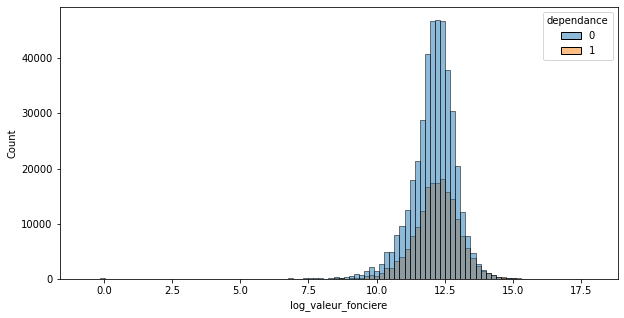

In [105]:
fig, ax = plt.subplots(figsize=(10, 5))

tmp = houses.copy()
tmp.loc[:, "log_valeur_fonciere"] = np.log(houses.valeur_fonciere)
sns.histplot(data=tmp, x="log_valeur_fonciere", hue="dependance", bins=100); 

### Variables géographiques

#### Régions & départements

In [182]:
regions_dpts = pd.read_csv(f"{ZIP_CODE_DIR}regions_departments.csv")
regions_dpts

,code_region,code_departement,nom_departement,nom_region
0,84,01,Ain,Auvergne-Rhône-Alpes
1,84,03,Allier,Auvergne-Rhône-Alpes
2,84,07,Ardèche,Auvergne-Rhône-Alpes
3,84,15,Cantal,Auvergne-Rhône-Alpes
4,84,26,Drôme,Auvergne-Rhône-Alpes
...,...,...,...,...
104,COM,984,Terres australes et antarctiques françaises,Collectivités d'Outre-Mer
105,COM,986,Wallis et Futuna,Collectivités d'Outre-Mer
106,COM,987,Polynésie française,Collectivités d'Outre-Mer
107,COM,988,Nouvelle-Calédonie,Collectivités d'Outre-Mer


In [183]:
houses = pd.merge(left=houses, right=regions_dpts, how="left", on="code_departement")

In [184]:
houses.shape

(605660, 39)

#### Grille communale de densité

On récupère une grille communale de densité depuis le [site](https://www.insee.fr/fr/information/6439600) de l"Insee. Cette grille comprend le code de la commune, son nombre d"habitants (2019) et une variable `degre_densite` à 7 niveaux : 

1. "Rural à habitat dispersé"
2. "Centres urbains intermédiaires"
3. "Bourgs ruraux"       
4. "Ceintures urbaines"            
5. "Rural à habitat très dispersé"
6. "Petites villes"                
7. "Grands centres urbains"

On décide d"y ajouter le nombre d"habitants pour les arrondissements de Paris, Marseille et Lyon. Pour ces 3 villes, la variable `degre_densite` vaut respectivement "Paris", "Marseille" et "Lyon". 

In [171]:
density = pd.read_csv(f"{DENSITY_DIR}municipality_density_levels.csv")
density

,code_commune,degre_densite,pop
0,01001,Rural à habitat dispersé,779
1,01002,Rural à habitat dispersé,256
2,01004,Centres urbains intermédiaires,14134
3,01005,Bourgs ruraux,1751
4,01006,Rural à habitat dispersé,112
...,...,...,...
34995,69385,Lyon,49546
34996,69386,Lyon,52621
34997,69387,Lyon,84310
34998,69388,Lyon,85980


In [185]:
houses = pd.merge(left=houses, right=density, how="left", on="code_commune")

In [186]:
houses.shape

(605660, 41)

### Variables temporelles

## Formattage des variables

## Seperation par zone géograhique